In [20]:
# 3rd party libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from tqdm import tqdm
import networkx as nx

In [23]:
def do_lines_intersect(p1, q1, p2, q2):
    """
    Check if two line segments (p1, q1) and (p2, q2) intersect.
    
    Parameters:
    - p1, q1: Endpoints of the first line segment.
    - p2, q2: Endpoints of the second line segment.
    
    Returns:
    - intersect: True if the line segments intersect, False otherwise.
    """
    def orientation(p, q, r):
        """
        Calculate the orientation of the ordered triplet (p, q, r).
        """
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0
        return 1 if val > 0 else 2

    def on_segment(p, q, r):
        # Check y and x coordinates to see if q is between p and r, if so, return True
        if min(p[0], r[0]) <= q[0] <= max(p[0], r[0]) and min(p[1], r[1]) <= q[1] <= max(p[1], r[1]):
            return True
        return False

    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    if o1 != o2 and o3 != o4:
        return True

    # Also if points are collinear, check if they are on the segment, if so return True. 
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False


def triangles_overlap(tri1, tri2):
    """
    Check if two triangles overlap by checking if any of their edges intersect,
    excluding shared edges or vertices.
    
    Parameters:
    - tri1: The vertices of the first triangle.
    - tri2: The vertices of the second triangle.
    
    Returns:
    - overlap: True if the triangles overlap, False otherwise.
    """
    edges1 = [(tri1[i], tri1[(i + 1) % 3]) for i in range(3)]
    edges2 = [(tri2[i], tri2[(i + 1) % 3]) for i in range(3)]
    
    for edge1 in edges1:
        for edge2 in edges2:
            if do_lines_intersect(edge1[0], edge1[1], edge2[0], edge2[1]):
                # Check if the edges are not shared
                if not (np.array_equal(edge1[0], edge2[0]) or np.array_equal(edge1[0], edge2[1]) or
                        np.array_equal(edge1[1], edge2[0]) or np.array_equal(edge1[1], edge2[1])):
                    return True
    return False


def check_overlapping_triangles(points, triangulation, npy_path="output/"):
    """
    Check if a Delaunay triangulation has overlapping triangles.
    
    Parameters:
    - points: The set of points used for the triangulation.
    - triangulation: The Delaunay triangulation object.
    
    Returns:
    - overlap: True if there are overlapping triangles, False otherwise.
    """
    num_overlapping_triangles = 0
    num_checks = 0
    overlap = False
    overlapping_triangles = []  # Store overlapping triangles for debugging
    
    triangle_stats = {}
    
    # Check for overlapping triangles
    for i, simplex1 in enumerate(triangulation.simplices):
        tri1 = points[simplex1]
        
        overlapped = []
        
        # Simplex to check against
        for j, simplex2 in enumerate(triangulation.simplices):
            if i >= j:  # Avoid checking the same pair twice
                continue
            #print(i, j)
            tri2 = points[simplex2]
            num_checks += 1
            
            # If triangles overlap, increment the count
            if triangles_overlap(tri1, tri2):
                # Print the first time
                #if num_overlapping_triangles == 0:
                #    tri1_str = ", ".join(map(str, tri1))
                #    tri2_str = ", ".join(map(str, tri2))
                #    print(f"\tTriangles overlap on triangle {tri1_str} and triangle {tri2_str}.")
                #    print("\t...")
                    
                # Add to list of overlapping triangles
                overlapping_triangles.append((tri1, tri2))
                overlap = True
                num_overlapping_triangles += 1
                
                # Add index to stats for current simplex index
                overlapped.append(j)
                #return True
                
        # Add to stats for current simplex index
        triangle_stats[i] = overlapped
    # Print the results
    #print("\tNumber of overlapping triangle checks failed:", num_overlapping_triangles, "/", num_checks)
    # Save the overlapping triangles
    if npy_path is not None:
    #    np.save(npy_path + "overlapping_triangles.npy", overlapping_triangles)
        np.save(npy_path + "triangle_stats.npy", triangle_stats)
    return overlap


def validate_triangulation(points, tri):
    """
    Validate a triangulation.
    
    Parameters:
    - points: The set of points used for the triangulation.
    
    Returns:
    - valid: True if the triangulation is valid, False otherwise.
    """
    # Check for overlapping triangles
    #print("Checking for no overlapping triangles...")
    if check_overlapping_triangles(points, tri):
        #print("\tOverlapping triangles check FAILED.")
        return False
    #print("\tOverlapping triangles check PASSED.")
    return True

In [63]:
def get_conflicts(points, triangulation):
    """
    Check if a Delaunay triangulation has overlapping triangles.
    
    Parameters:
    - points: The set of points used for the triangulation.
    - triangulation: The Delaunay triangulation object.
    
    Returns:
    - overlap: True if there are overlapping triangles, False otherwise.
    """
    conflicts = []
    
    # Check for overlapping triangles
    for i, simplex1 in enumerate(triangulation.simplices):
        tri1 = points[simplex1]
                
        # Simplex to check against
        for j, simplex2 in enumerate(triangulation.simplices):
            if i >= j:  # Avoid checking the same pair twice
                continue
            tri2 = points[simplex2]
            
            # If triangles overlap, increment the count
            if triangles_overlap(tri1, tri2):
                # Add index to stats for current simplex index
                conflicts.append((i, j))
                print(tri1, tri2)
    return conflicts

Setup example Delaunay triangulation points

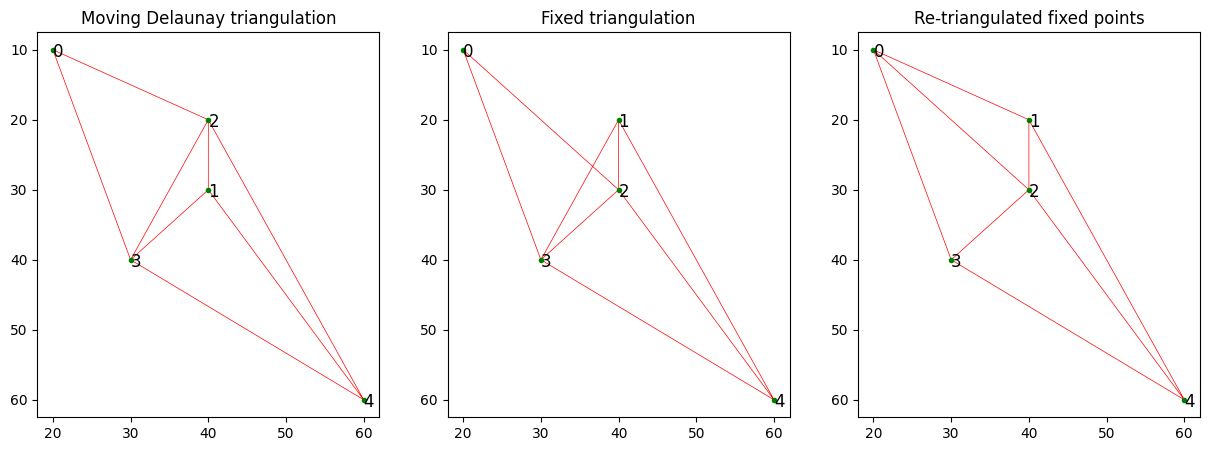

Validating triangulations...
Triangulation 1 valid: True
Triangulation 2 valid: False
Triangulation 3 valid: True


In [24]:
mpts = np.array([
    [10, 20],  # 0
    [30, 40],  # 1
    [20, 40],  # 2
    [40, 30],
    [60, 60]]) # 3


# Swap 1 and 2 around
fpts = np.array([
    mpts[0],
    mpts[2],
    mpts[1], 
    mpts[3],
    mpts[4]]) 

mtri = Delaunay(mpts)
ftri = Delaunay(fpts)

# 1. Moving Delaunay triangulation
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(mpts[:, 1], mpts[:, 0], 'go', markersize=3)
for i in range(len(mpts)):
    pt = mpts[i]
    plt.text(pt[1], pt[0] + 1, str(i), fontsize=12)
plt.triplot(mpts[:, 1], mpts[:, 0], mtri.simplices, color='red', linewidth=0.5)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.title('Moving Delaunay triangulation')

# 2. Fixed triangulation
plt.subplot(1, 3, 2)
plt.plot(fpts[:, 1], fpts[:, 0], 'go', markersize=3)
for i in range(len(fpts)):
    pt = fpts[i]
    plt.text(pt[1], pt[0] + 1, str(i), fontsize=12)
plt.triplot(fpts[:, 1], fpts[:, 0], mtri.simplices, color='red', linewidth=0.5)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.title('Fixed triangulation')

# 3. Re-triangulated fixed points
plt.subplot(1, 3, 3)
plt.plot(fpts[:, 1], fpts[:, 0], 'go', markersize=3)
for i in range(len(fpts)):
    pt = fpts[i]
    plt.text(pt[1], pt[0] + 1, str(i), fontsize=12)
plt.triplot(fpts[:, 1], fpts[:, 0], ftri.simplices, color='red', linewidth=0.5)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.title('Re-triangulated fixed points')
plt.show()

# 4. Validate triangulations
print("Validating triangulations...")
valid_1 = validate_triangulation(mpts, mtri)
valid_2 = validate_triangulation(fpts, mtri)
valid_3 = validate_triangulation(fpts, ftri)
print(f"Triangulation 1 valid: {valid_1}")
print(f"Triangulation 2 valid: {valid_2}")  # Should be False
print(f"Triangulation 3 valid: {valid_3}")  # Should be True


Build conflict graph

[[20 40]
 [40 30]
 [60 60]] [[40 30]
 [30 40]
 [10 20]]
[[30 40]
 [40 30]
 [20 40]] [[40 30]
 [30 40]
 [10 20]]
[(0, 3), (2, 3)]


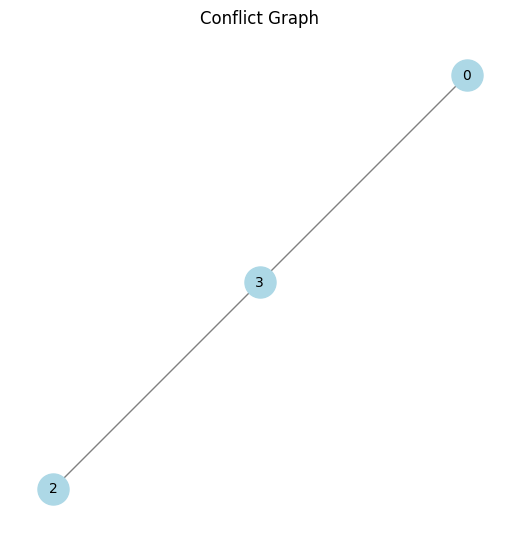

In [64]:
conflicts = get_conflicts(fpts, mtri)
print(conflicts)

# Build a conflict graph
conflict_graph = nx.Graph()
for nodes in conflicts:
    conflict_graph.add_edge(nodes[0], nodes[1])

# Visualize the graph
plt.figure(figsize=(5, 5))
nx.draw(conflict_graph, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
plt.title("Conflict Graph")
plt.show()

Dynamically update conflicts

[(0, 3), (2, 3)]
[[10 20]
 [30 40]
 [20 40]
 [40 30]
 [60 60]]
Simplex: [3 2 0]
Points removed: {3}
Remaining points in A: [[10 20]
 [30 40]
 [20 40]
 [60 60]]
Remaining points in B: [[10 20]
 [20 40]
 [30 40]
 [60 60]]


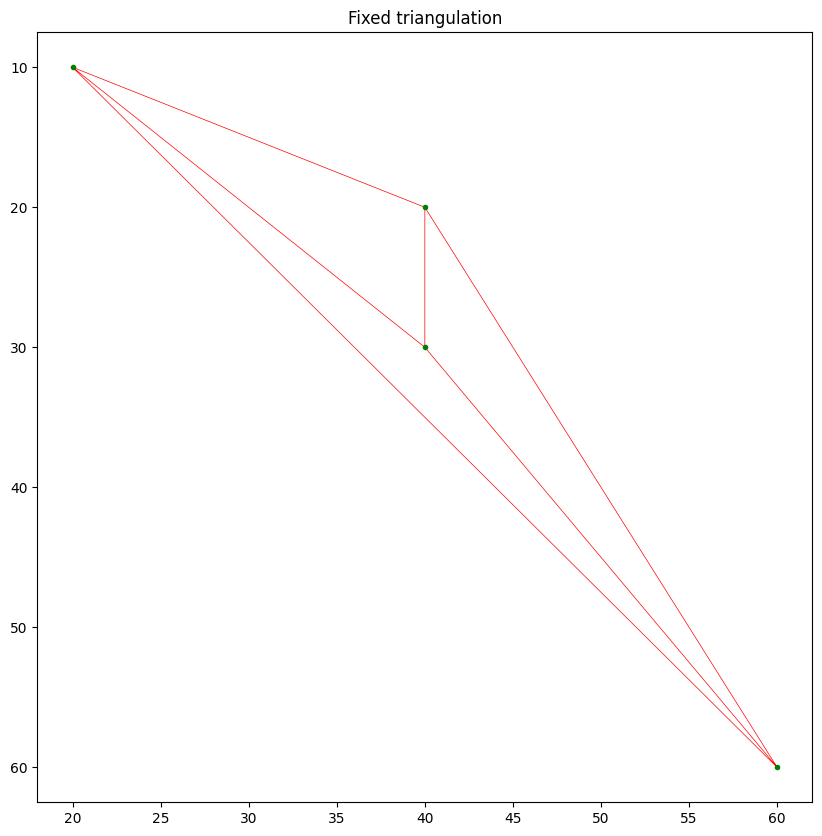

[]
True


In [62]:
def get_triangles(tri, points):
    """Returns the coordinates of each triangle's vertices."""
    return [points[simplex] for simplex in tri.simplices]

conflicts = get_conflicts(fpts, mtri)
print(conflicts)

# Build a conflict graph
conflict_graph = nx.Graph()
for nodes in conflicts:
    conflict_graph.add_edge(nodes[0], nodes[1])

points_to_remove = set()
points_A = mpts.copy()
points_B = fpts.copy()
tri_A = Delaunay(points_A)
print(points_A)

while conflicts:
    # Find the node with the most conflicts
    node, _ = max(conflict_graph.degree, key=lambda x: x[1])
    simplex = tri_A.simplices[node]
    print("Simplex:", simplex)
    points_to_remove.add(node)

    # Remove the point from points_A and re-triangulate
    points_A = np.delete(points_A, list(points_to_remove), axis=0)
    points_B = np.delete(points_B, list(points_to_remove), axis=0)
    tri_A = Delaunay(points_A)
    
    # Re-check conflicts and update conflict graph
    conflicts = get_conflicts(points_B, tri_A)
    conflict_graph.clear()
    for tri1_idx, tri2_idx in conflicts:
        for p1 in tri_A.simplices[tri1_idx]:
            for p2 in tri_A.simplices[tri2_idx]:
                if p1 != p2:
                    conflict_graph.add_edge(p1, p2)

print("Points removed:", points_to_remove)
print("Remaining points in A:", points_A)
print("Remaining points in B:", points_B)


plt.figure(figsize=(10, 10))
plt.plot(points_B[:, 1], points_B[:, 0], 'go', markersize=3)
for i in range(len(points_B)):
    pt = points_B[i]
#    plt.text(points_B[1], points_B[0] + 1, str(i), fontsize=12)
plt.triplot(points_B[:, 1], points_B[:, 0], tri_A.simplices, color='red', linewidth=0.5)
plt.gca().invert_yaxis()  # Invert the y-axis
plt.title('Fixed triangulation')
plt.show()

print(conflicts)
print(validate_triangulation(points_B, tri_A))  # Should be True

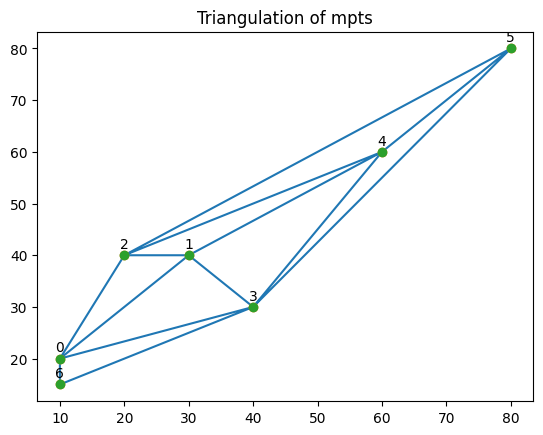

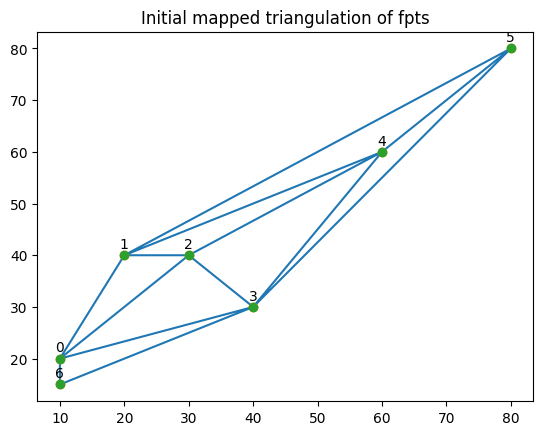

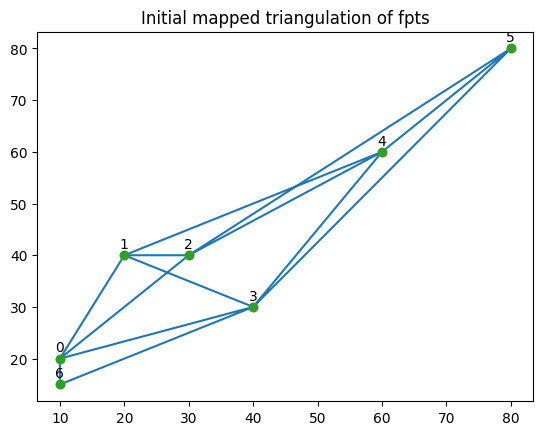

Resolved points: [[40 30]
 [60 60]
 [80 80]]
Removed points: {(10, 15), (20, 40), (30, 40), (10, 20)}


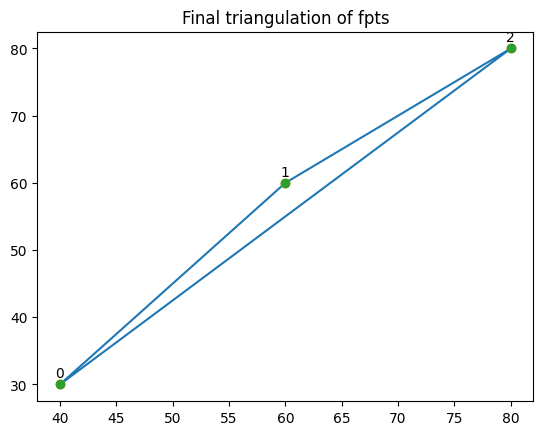

In [73]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from itertools import combinations

# Example points
mpts = np.array([
    [10, 20],  # 0
    [30, 40],  # 1
    [20, 40],  # 2
    [40, 30],  # 3
    [60, 60],  # 4
    [80, 80],
    [10, 15]
])

# Swapped points in fpts
fpts = np.array([
    mpts[0],
    mpts[2],
    mpts[1], 
    mpts[3],
    mpts[4],
    mpts[5],
    mpts[6]
])

def plot_triangulation(points, triangles, title="Triangulation"):
    plt.triplot(points[:, 0], points[:, 1], triangles.simplices, 'o-')
    plt.plot(points[:, 0], points[:, 1], 'o')
    for i, txt in enumerate(range(len(points))):
        plt.annotate(txt, (points[i, 0], points[i, 1]), textcoords="offset points", xytext=(0,5), ha='center')
    plt.title(title)
    plt.show()

# Step 1: Delaunay triangulation of mpts
tri_mpts = Delaunay(mpts)
plot_triangulation(mpts, tri_mpts, title="Triangulation of mpts")

# Step 2: Map triangulation edges from mpts to fpts
tri_fpts = Delaunay(fpts)
plot_triangulation(fpts, tri_fpts, title="Initial mapped triangulation of fpts")
plot_triangulation(fpts, tri_mpts, title="Initial mapped triangulation of fpts")

# Step 3: Identify conflicts in the triangulation of fpts
def find_conflicts(triangles):
    overlapping_pairs = set()
    for i, j in combinations(range(len(triangles.simplices)), 2):
        t1, t2 = triangles.simplices[i], triangles.simplices[j]
        # Check for intersection between two triangles
        if any(np.intersect1d(t1, t2)):
            overlapping_pairs.update([i, j])
    return overlapping_pairs


# Function to iteratively remove points to resolve conflicts
def remove_minimal_points(fpts):
    points = fpts.copy()
    removed_points = set()
    
    # Initial triangulation and conflict detection
    current_triangulation = Delaunay(points)
    conflicts = find_conflicts(current_triangulation)
    
    while conflicts:
        # Identify the unique coordinates of points involved in the current conflicts
        conflict_points = np.unique(points[np.concatenate([current_triangulation.simplices[list(conflicts)]]).flatten()], axis=0)
        
        # Select the first point in conflict to remove
        point_to_remove = conflict_points[0]
        
        # Remove the point from the points set
        points = np.array([p for p in points if not np.array_equal(p, point_to_remove)])
        removed_points.add(tuple(point_to_remove))
        
        # Re-triangulate with updated points and detect conflicts again
        current_triangulation = Delaunay(points)
        conflicts = find_conflicts(current_triangulation)
        
    return points, removed_points

resolved_points, removed_points = remove_minimal_points(fpts)
print(f"Resolved points: {resolved_points}")
print(f"Removed points: {removed_points}")

# Final triangulation after removal
final_triangulation = Delaunay(resolved_points)
plot_triangulation(resolved_points, final_triangulation, title="Final triangulation of fpts")
